# ML - Problem Set 2: Predicting Poverty

El objetivo principal es construir un modelo predictivo de la pobreza de los hogares. Nótese que un hogar se clasifica como

\begin{equation}
    Poor = I \left( Inc < Pl \right)
\end{equation}

donde $I$ es una función indicadora que toma uno si el ingreso familiar está por debajo de una determinada línea de pobreza.

## Paso 1. Procesamiento de datos

In [1]:
# Importar librerias

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importar datos

sample = pd.read_csv('sample_submission.csv')
test_hogares = pd.read_csv('test_hogares.csv')
train_hogares = pd.read_csv('train_hogares.csv')
test_personas = pd.read_csv('test_personas.csv')
train_personas = pd.read_csv('train_personas.csv')

In [3]:
# Limpiar datos

common_columns_hogares = train_hogares.columns.intersection(test_hogares.columns) #obtener columnas comunes entre train_hogares y test_hogares
common_columns_personas = train_personas.columns.intersection(test_personas.columns) #obtener columnas comunes entre train_personas y test_personas
train_hogares = train_hogares[common_columns_hogares] #filtrar las columnas para alinear los datos
train_personas = train_personas[common_columns_personas] #filtrar las columnas para alinear los datos

columnas_deseadas = ['id', 'Orden', 'Clase', 'Dominio', 'P6020', 'P6040', 'P6050', 'P6090', 'P6100',
                     'P6210', 'P6210s1', 'P6240', 'Oficio', 'P6426', 'P6430', 'P6590', 'P6800',
                     'P6870', 'P6920', 'P7090', 'P7110', 'P7120', 'P7350', 'P7495', 'P7510s5',
                     'Pet', 'Oc', 'Des', 'Ina', 'Fex_c', 'Depto', 'Fex_dpto'] #datos mas relevantes

train_personas = train_personas[columnas_deseadas]
test_personas = test_personas[columnas_deseadas]

train_personas['P6210s1'] = train_personas['P6210s1'].where(train_personas['P6210s1'] <= 15, pd.NA) #eliminar nivel educativo 99
test_personas['P6210s1'] = test_personas['P6210s1'].where(test_personas['P6210s1'] <= 15, pd.NA) #eliminar nivel educativo 99

<ipython-input-3-4931c81a3550>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_personas['P6210s1'] = test_personas['P6210s1'].where(test_personas['P6210s1'] <= 15, pd.NA) #eliminar nivel educativo 99


In [4]:
# Imputar datos falntantes

# Crear imputadores
imputador_moda = SimpleImputer(strategy='most_frequent')  # Para variables categóricas
imputador_mediana = SimpleImputer(strategy='median')  # Para variables numéricas

# Función para imputar datos
def imputar_datos(df):
    # Separar columnas numéricas y categóricas
    columnas_numericas = df.select_dtypes(include=['number']).columns
    columnas_categoricas = df.select_dtypes(exclude=['number']).columns

    # Imputar numéricas con la mediana
    if not columnas_numericas.empty:
        df[columnas_numericas] = imputador_mediana.fit_transform(df[columnas_numericas])

    # Imputar categóricas con la moda
    if not columnas_categoricas.empty:
        df[columnas_categoricas] = imputador_moda.fit_transform(df[columnas_categoricas])

# Aplicar imputación a todos los DataFrames
imputar_datos(test_hogares)
imputar_datos(train_hogares)
imputar_datos(test_personas)
imputar_datos(train_personas)

print(train_personas.columns.tolist())
print(test_personas.columns.tolist())
print(train_hogares.columns.tolist())
print(test_hogares.columns.tolist())

['id', 'Orden', 'Clase', 'Dominio', 'P6020', 'P6040', 'P6050', 'P6090', 'P6100', 'P6210', 'P6210s1', 'P6240', 'Oficio', 'P6426', 'P6430', 'P6590', 'P6800', 'P6870', 'P6920', 'P7090', 'P7110', 'P7120', 'P7350', 'P7495', 'P7510s5', 'Pet', 'Oc', 'Des', 'Ina', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Orden', 'Clase', 'Dominio', 'P6020', 'P6040', 'P6050', 'P6090', 'P6100', 'P6210', 'P6210s1', 'P6240', 'Oficio', 'P6426', 'P6430', 'P6590', 'P6800', 'P6870', 'P6920', 'P7090', 'P7110', 'P7120', 'P7350', 'P7495', 'P7510s5', 'Pet', 'Oc', 'Des', 'Ina', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130', 'P5140', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto']
['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130', 'P5140', 'Nper', 'Npersug', 'Li', 'Lp', 'Fex_c', 'Depto', 'Fex_dpto']


## Fusionar individuos con hogares

In [5]:
# Crear una nueva variable que sea promedio educativo por hogar

# Agrupar por 'id' y sumar los valores de 'P6210s1' para cada hogar
promedio_educacion_train = train_personas.groupby('id')['P6210s1'].sum().reset_index()
promedio_educacion_train.rename(columns={'P6210s1': 'Suma_P6210s1'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
train_hogares = train_hogares.merge(promedio_educacion_train, on='id', how='left')

# Calcular el promedio de educación por hogar
train_hogares['Promedio_Educacion'] = train_hogares['Suma_P6210s1'] / train_hogares['Nper']

# Agrupar por 'id' y sumar los valores de 'P6210s1' para cada hogar
promedio_educacion_test = test_personas.groupby('id')['P6210s1'].sum().reset_index()
promedio_educacion_test.rename(columns={'P6210s1': 'Suma_P6210s1'}, inplace=True)

# Unir con el DataFrame de hogares en base al 'id'
test_hogares = test_hogares.merge(promedio_educacion_test, on='id', how='left')

# Calcular el promedio de educación por hogar
test_hogares['Promedio_Educacion'] = test_hogares['Suma_P6210s1'] / test_hogares['Nper']

In [6]:
# Crear una nueva variable que sea promedio de personas por habitacion

train_hogares['Aglomeracion'] = train_hogares['Nper'] / train_hogares['P5010']

# Calcular el ratio de personas por dormitorio (Aglomeracion) en test_hogares
test_hogares['Aglomeracion'] = test_hogares['Nper'] / test_hogares['P5010']

## Estadistica descriptiva


Estadísticas descriptivas para los hogares
Estadísticas descriptivas para variables numéricas:
               P5000          P5010         P5100         P5130         P5140  \
count  164960.000000  164960.000000  1.649600e+05  1.649600e+05  1.649600e+05   
mean        3.390379       1.989361  5.143223e+05  4.412952e+05  4.026272e+05   
std         1.239474       0.898158  1.131946e+06  3.250409e+06  9.052601e+05   
min         1.000000       1.000000  9.800000e+01  9.800000e+01  2.000000e+01   
25%         3.000000       1.000000  5.000000e+05  3.000000e+05  3.800000e+05   
50%         3.000000       2.000000  5.000000e+05  3.500000e+05  3.800000e+05   
75%         4.000000       3.000000  5.000000e+05  4.000000e+05  3.800000e+05   
max        98.000000      15.000000  2.800000e+08  6.000000e+08  3.000000e+08   

                Nper        Npersug             Li             Lp  \
count  164960.000000  164960.000000  164960.000000  164960.000000   
mean        3.292368       3.279571 

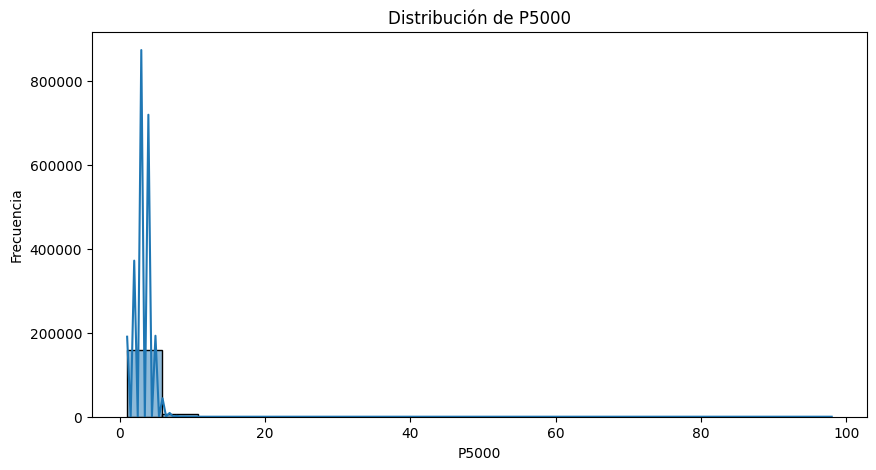

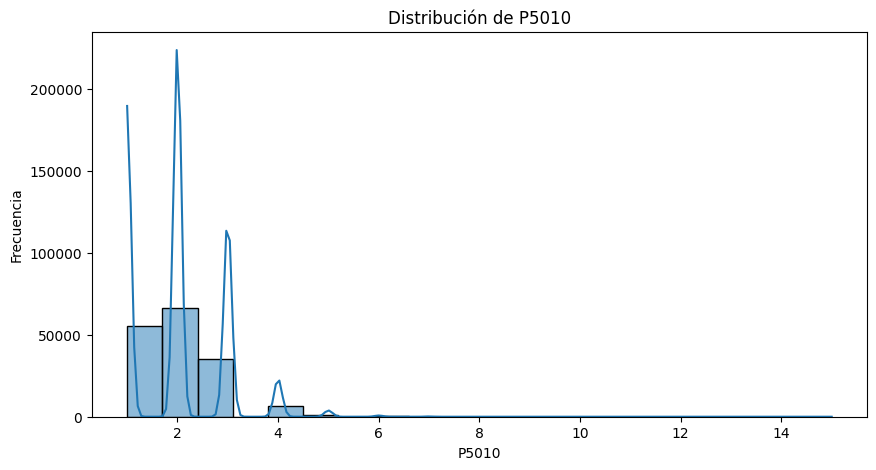

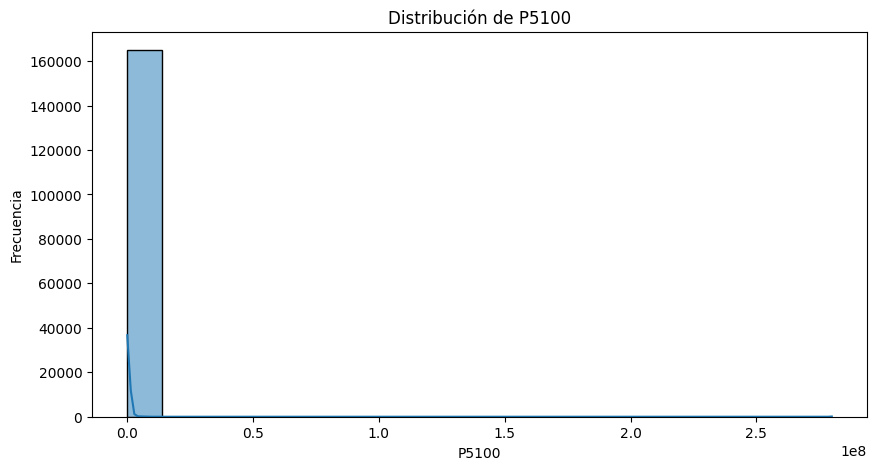

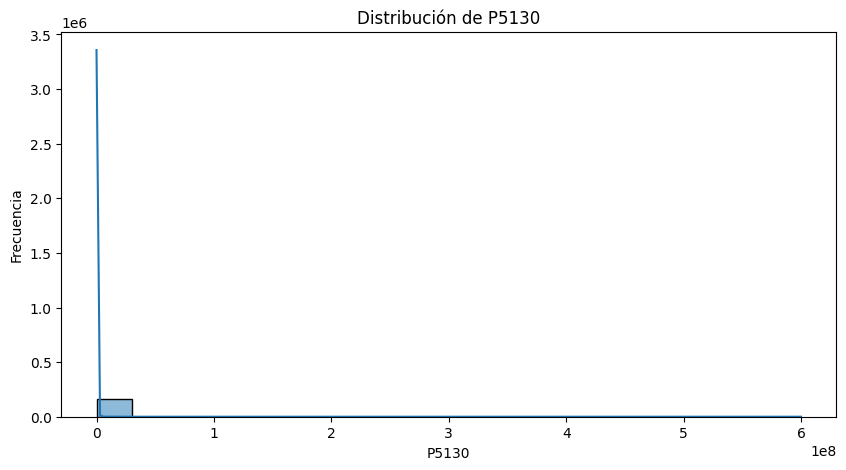

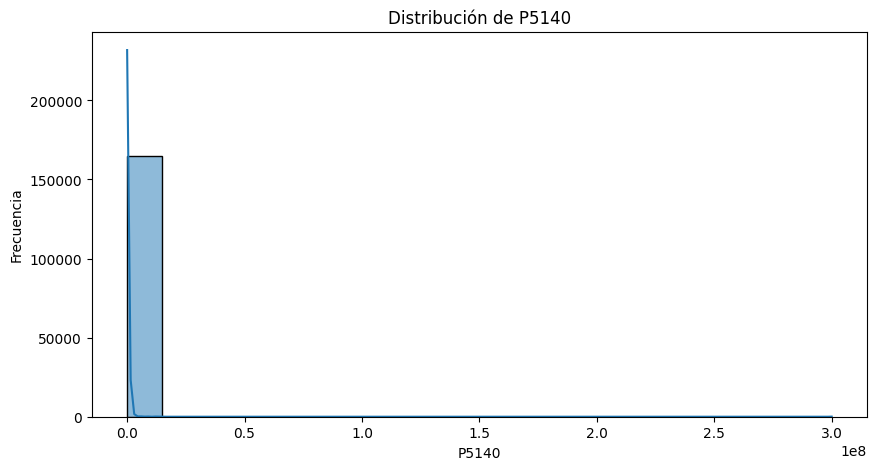

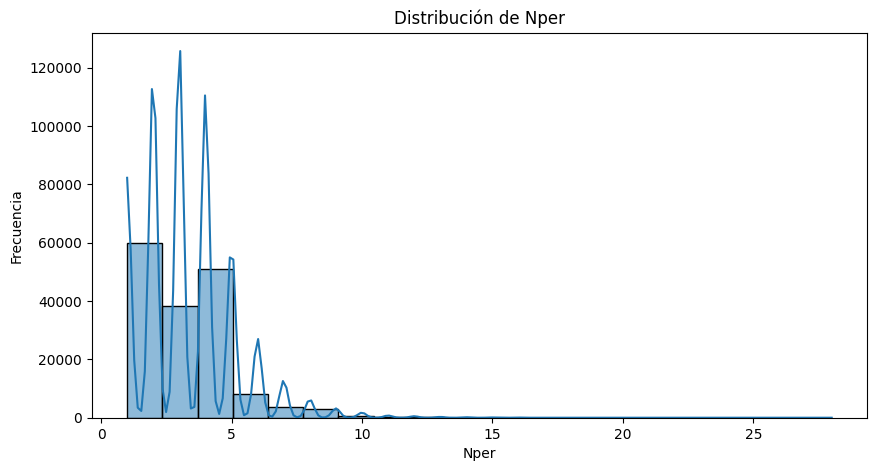

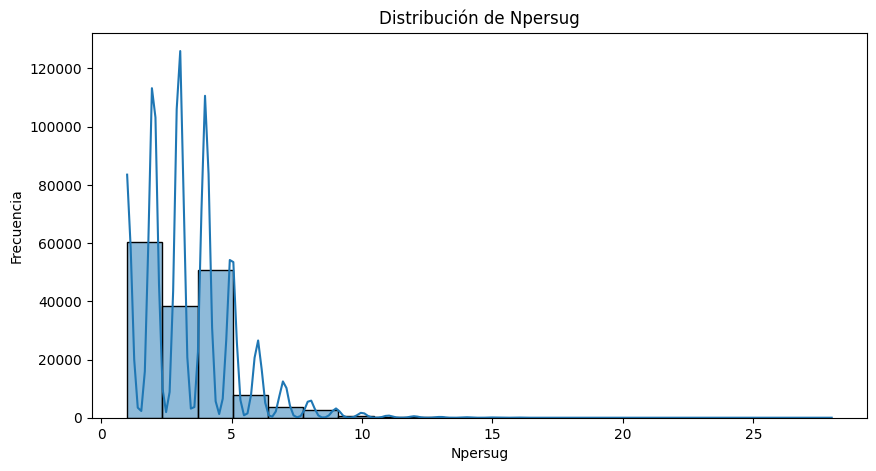

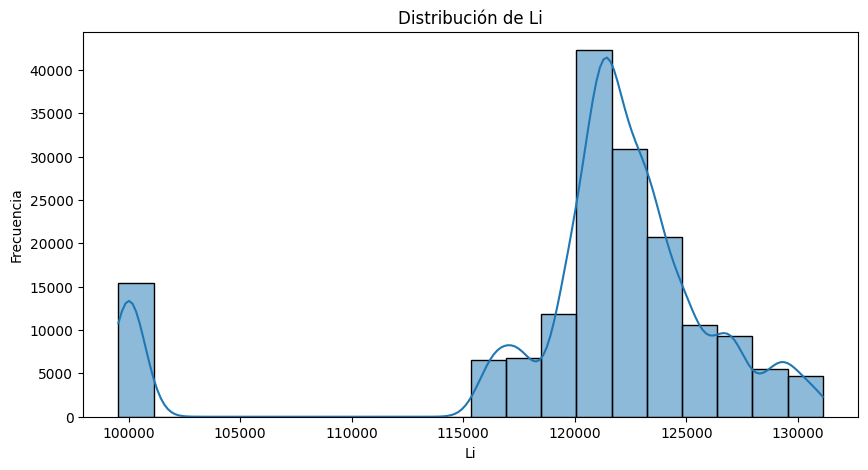

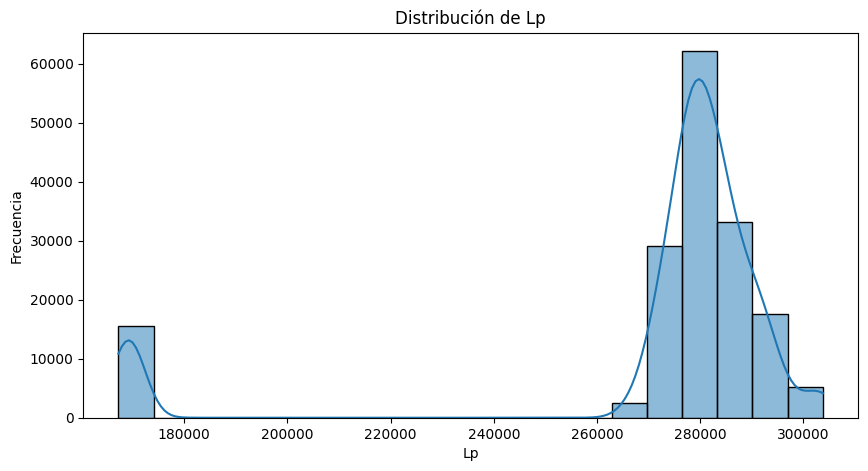

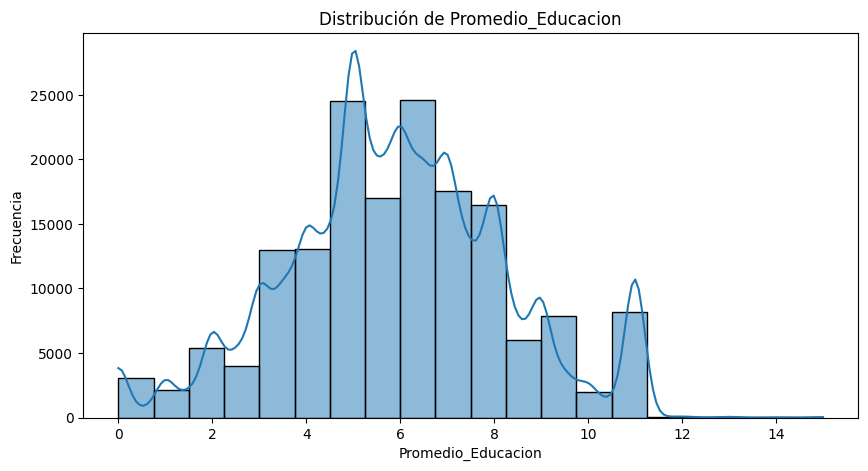

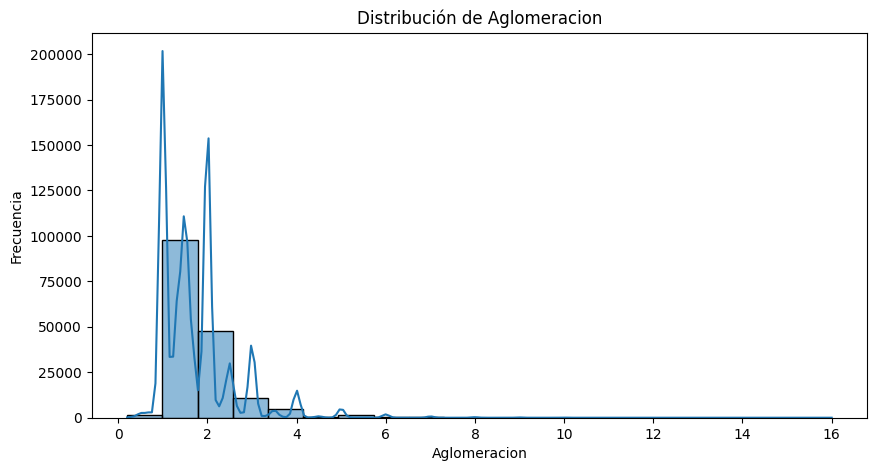

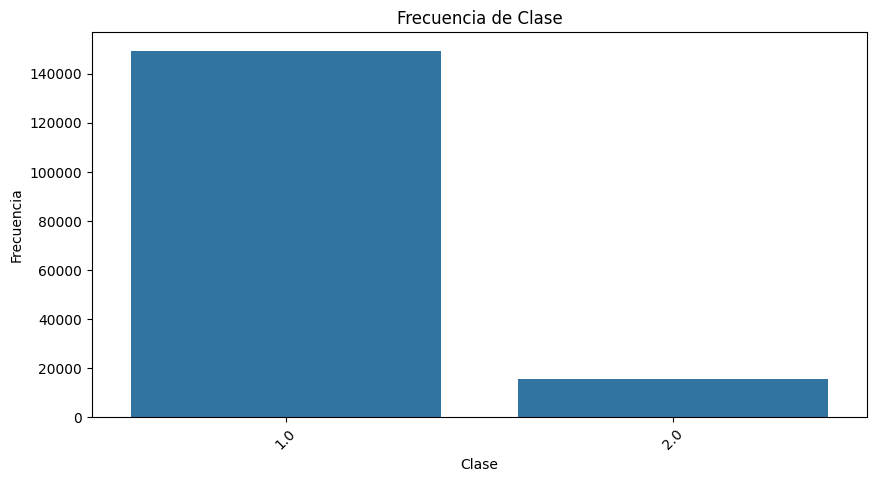

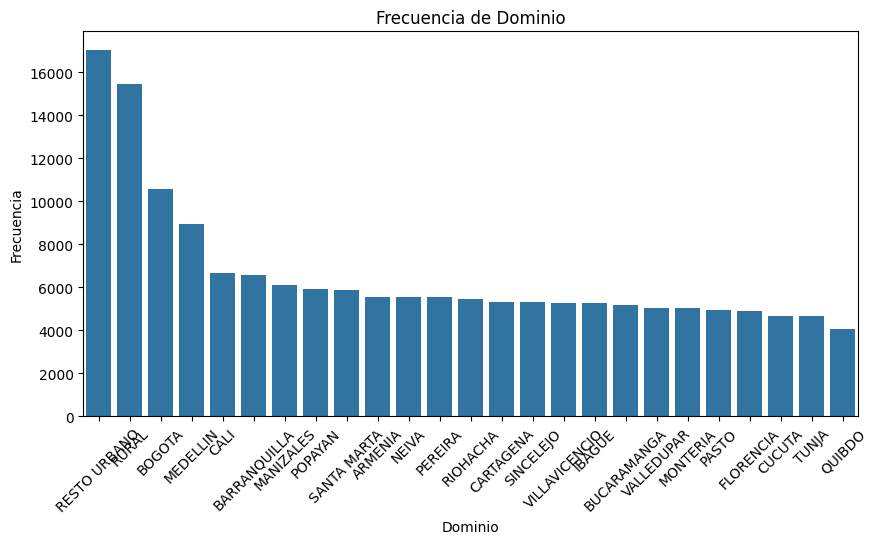

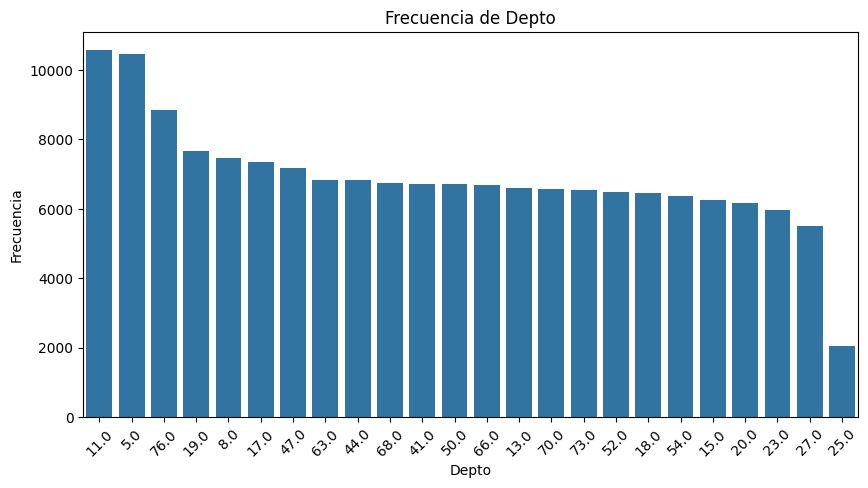


Estadísticas descriptivas para las personas
Estadísticas descriptivas para variables numéricas:
               P6040        P6210s1          P6800          P6870  \
count  543109.000000  543109.000000  543109.000000  543109.000000   
mean       33.552710       5.963865      46.540335       2.858991   
std        21.652844       3.328696      10.737902       2.410781   
min         0.000000       0.000000       1.000000       1.000000   
25%        16.000000       4.000000      48.000000       2.000000   
50%        31.000000       5.000000      48.000000       2.000000   
75%        50.000000       9.000000      48.000000       2.000000   
max       110.000000      15.000000     130.000000       9.000000   

               P7495        P7510s5  
count  543109.000000  543109.000000  
mean        1.924404       1.998685  
std         0.264351       0.119171  
min         1.000000       1.000000  
25%         2.000000       2.000000  
50%         2.000000       2.000000  
75%         2.0

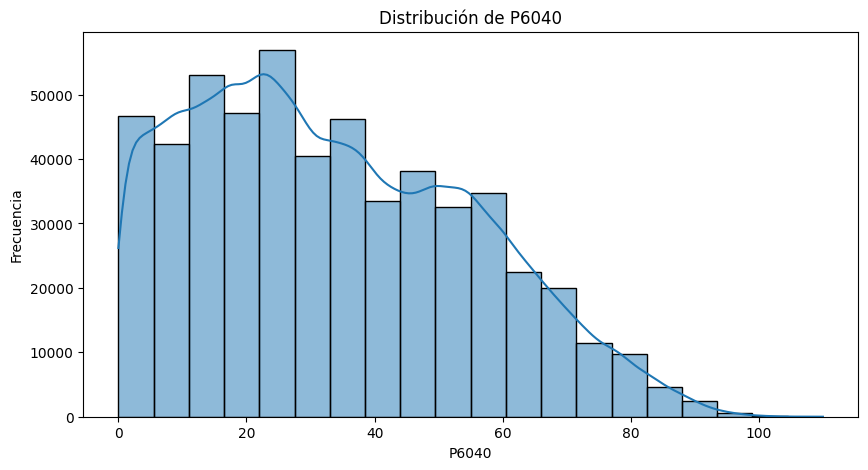

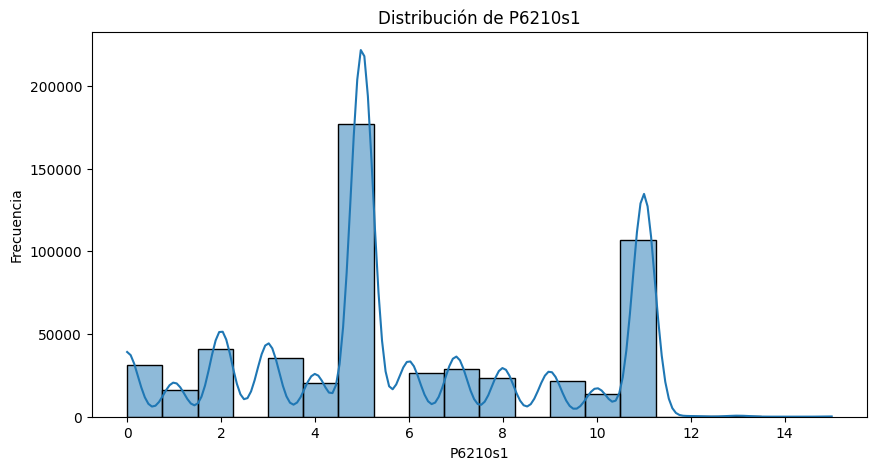

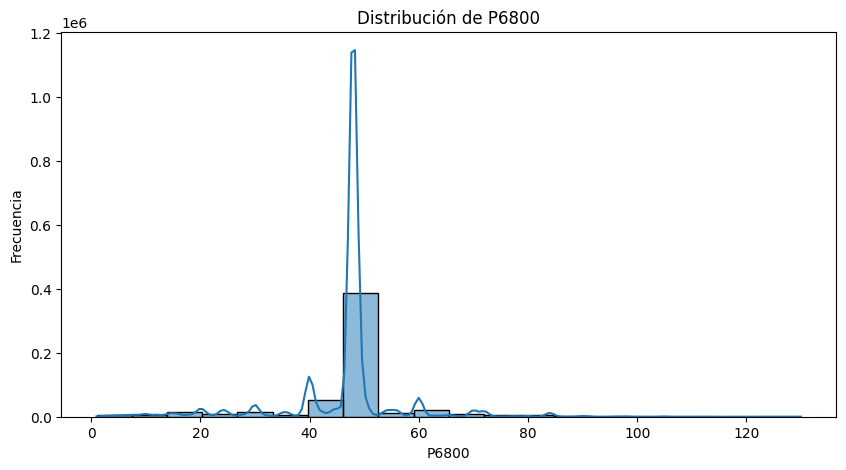

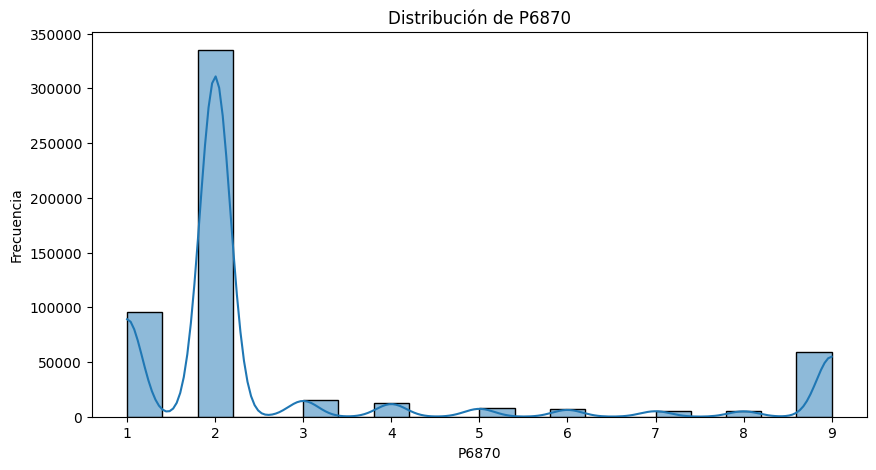

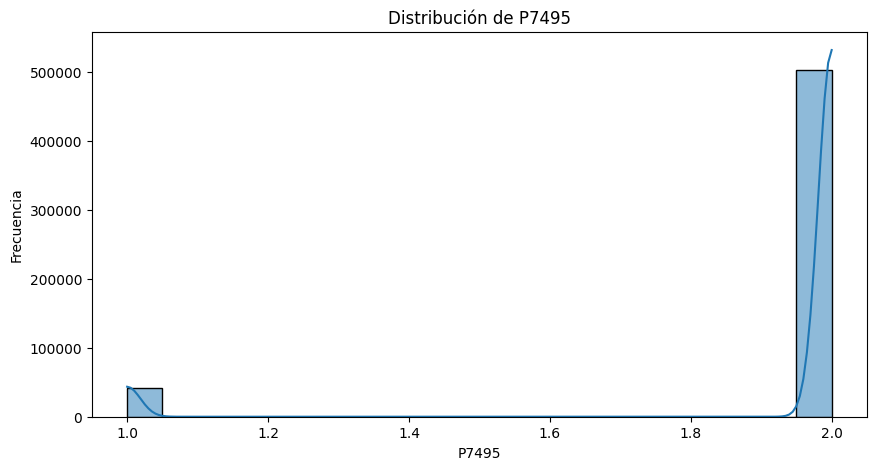

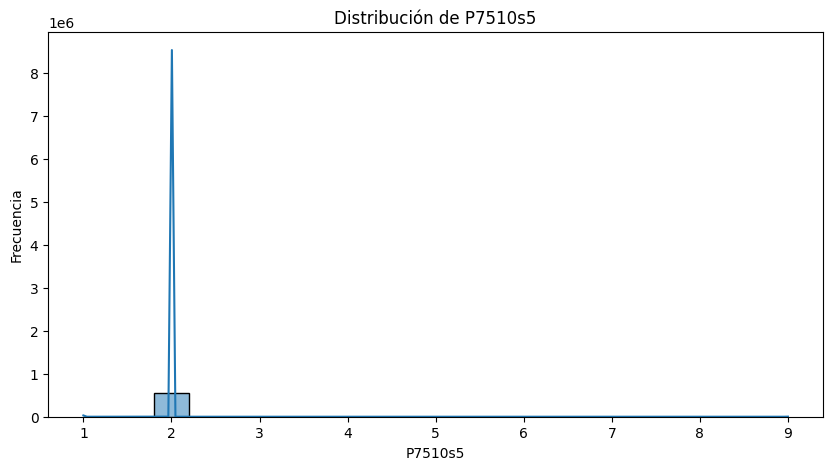

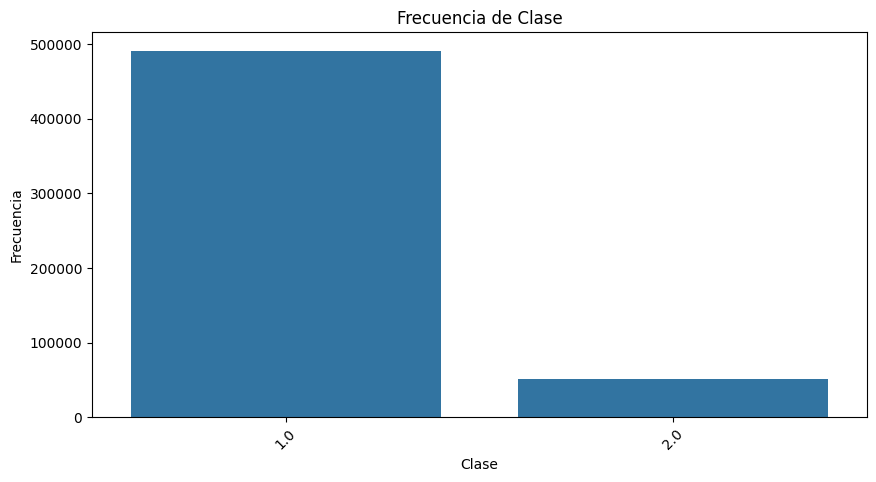

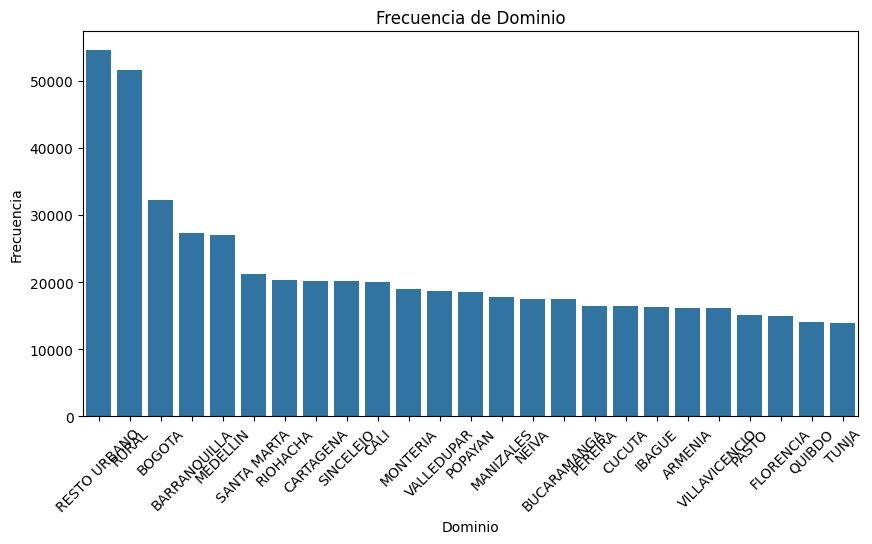

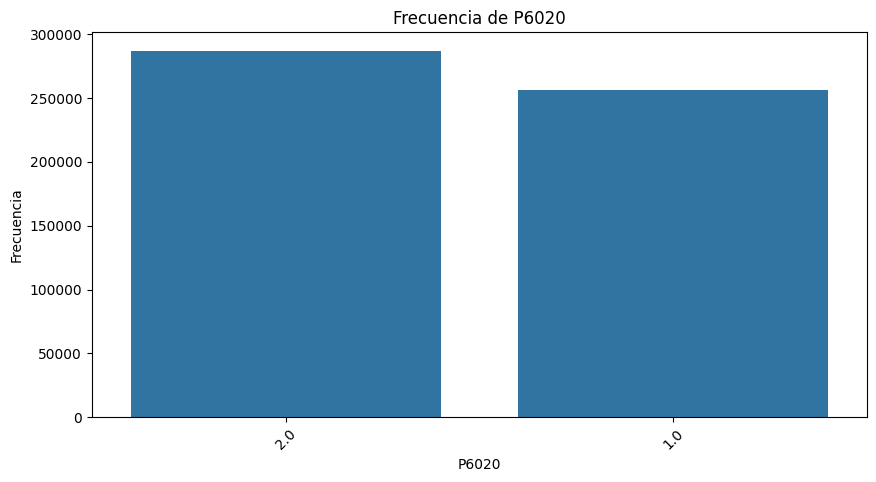

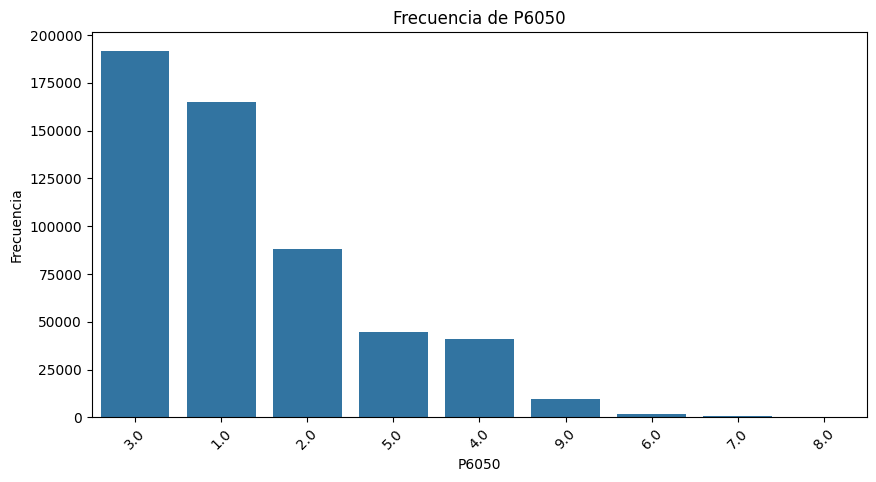

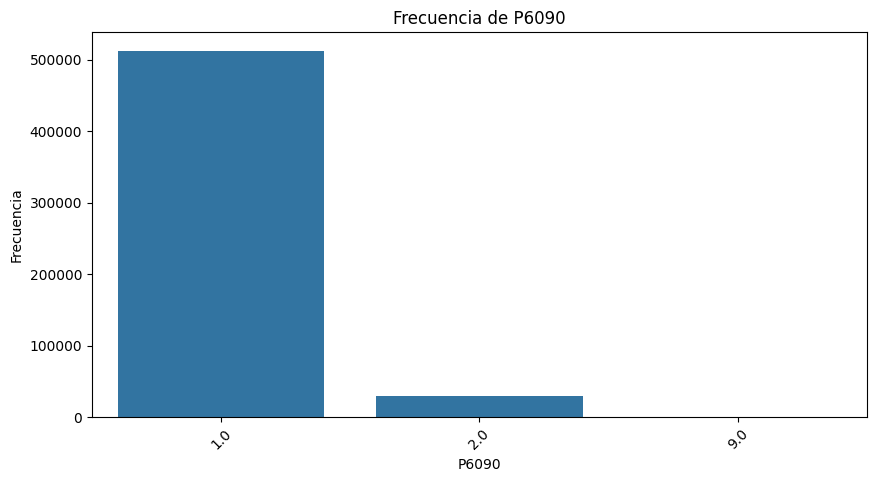

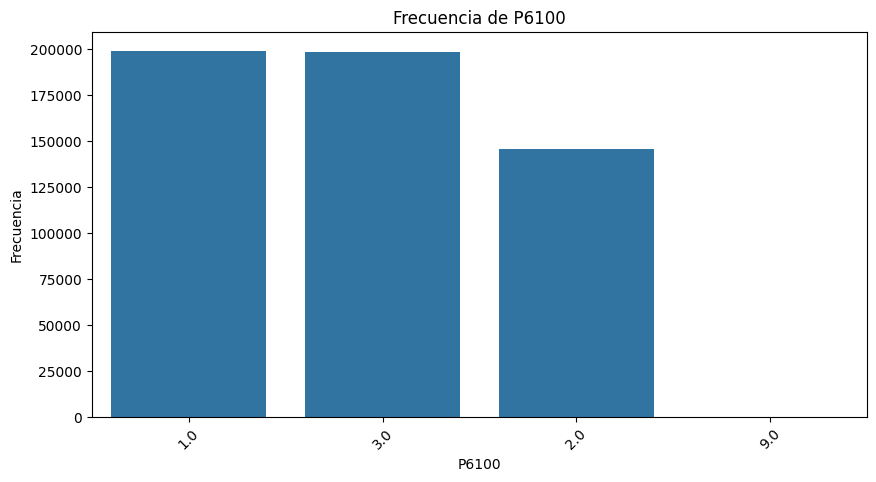

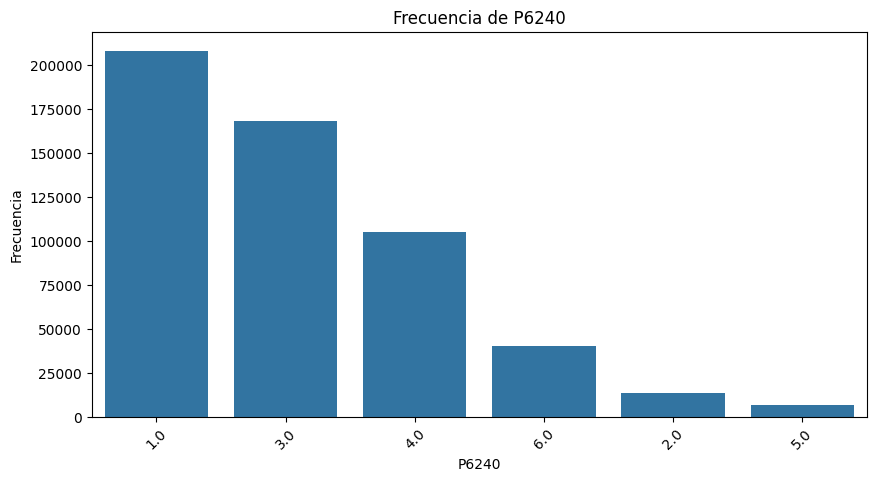

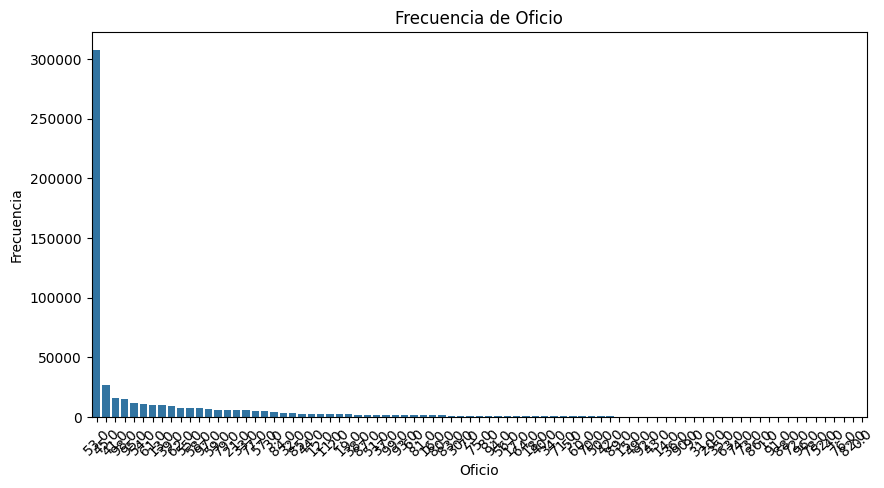

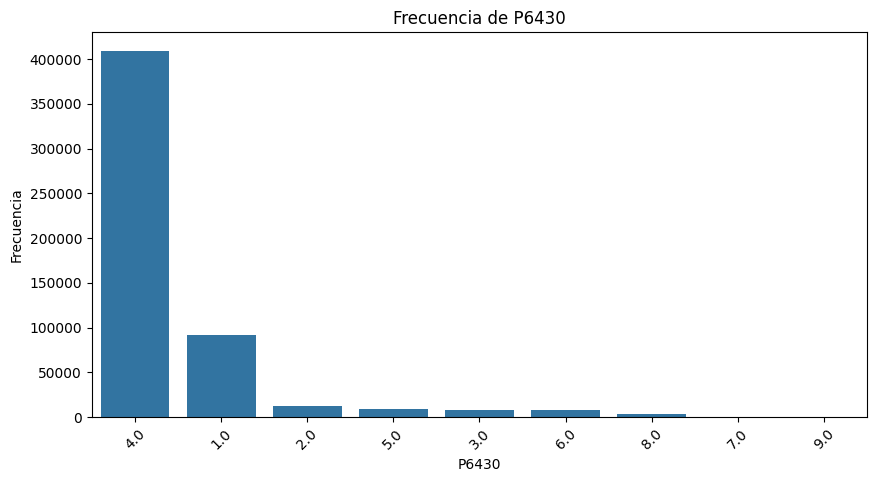

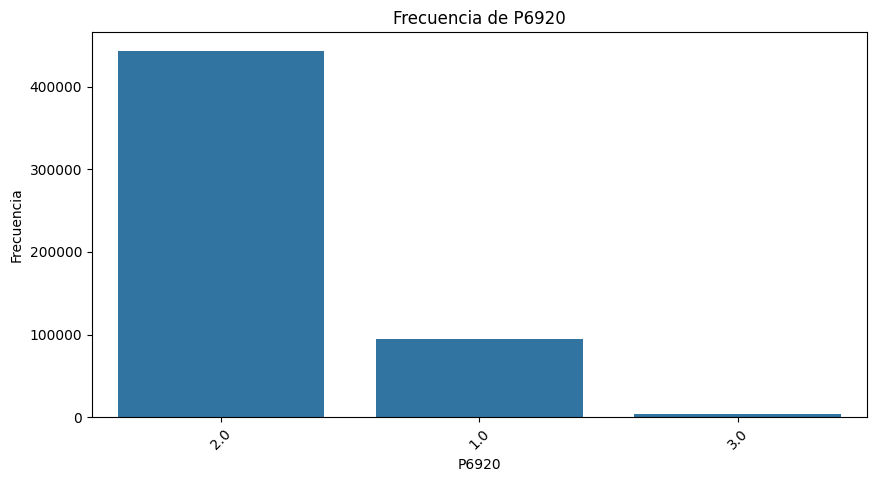

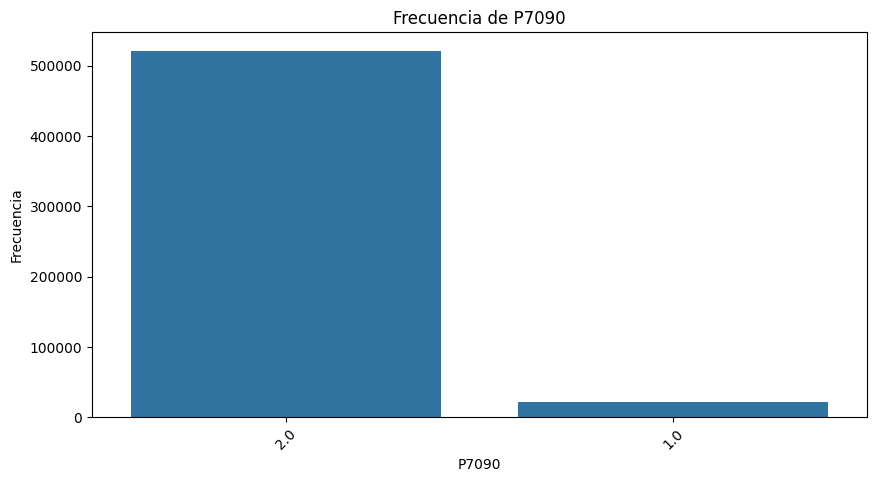

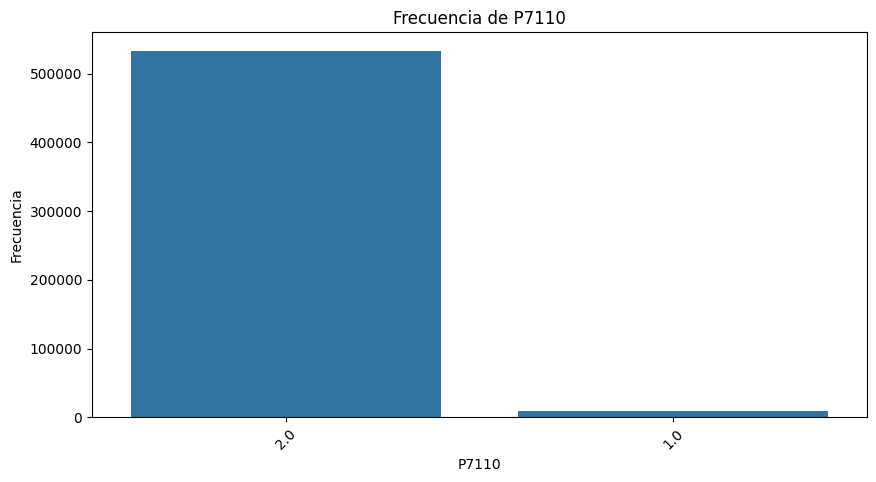

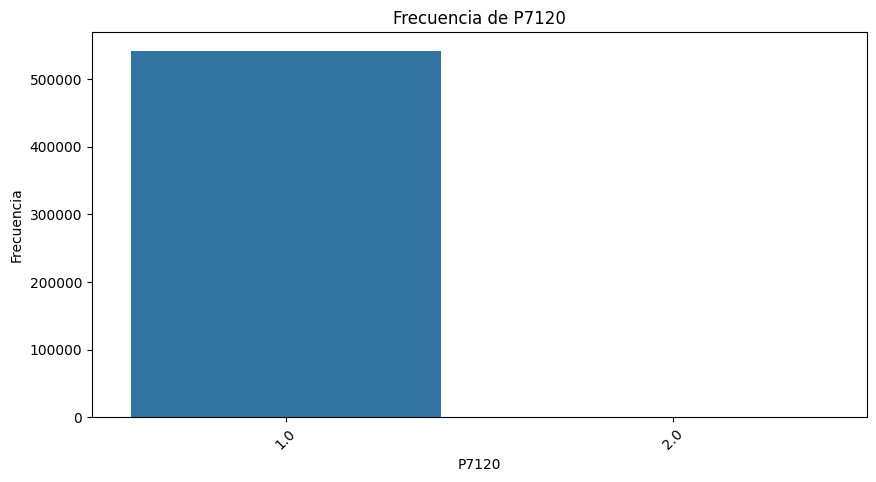

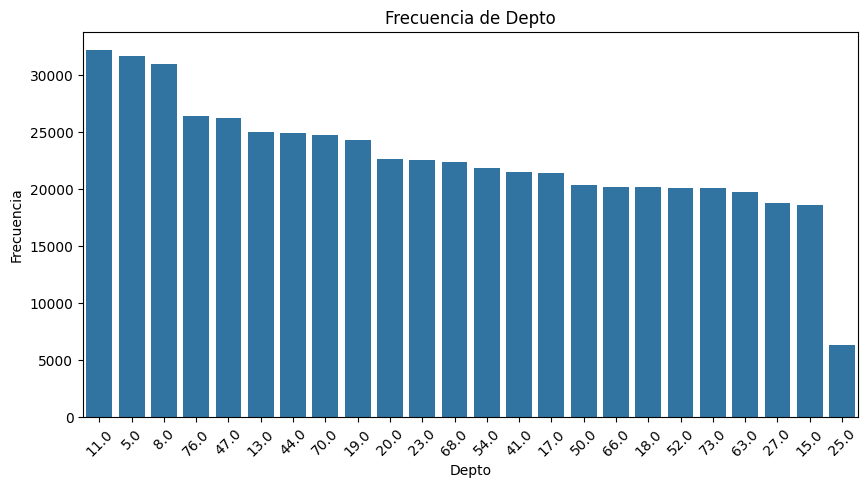

In [8]:
# Función para generar estadísticas descriptivas y gráficos

def generar_estadisticas_descriptivas(df, variables_numericas, variables_categoricas):
    # Estadísticas descriptivas para variables numéricas
    print("Estadísticas descriptivas para variables numéricas:")
    print(df[variables_numericas].describe())

    # Estadísticas de frecuencia para variables categóricas
    print("\nEstadísticas de frecuencia para variables categóricas:")
    for var in variables_categoricas:
        print(f"\nFrecuencia para {var}:")
        print(df[var].value_counts())

    # Generar histogramas para variables numéricas
    for var in variables_numericas:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[var], kde=True, bins=20)
        plt.title(f"Distribución de {var}")
        plt.xlabel(var)
        plt.ylabel("Frecuencia")
        plt.show()

    # Gráficos de barras para variables categóricas
    for var in variables_categoricas:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=var, data=df, order=df[var].value_counts().index)
        plt.title(f"Frecuencia de {var}")
        plt.xlabel(var)
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45)
        plt.show()

# Variables relevantes para los DataFrames de hogares y personas
variables_numericas_hogares = ['P5000', 'P5010', 'P5100', 'P5130', 'P5140', 'Nper', 'Npersug', 'Li', 'Lp', 'Promedio_Educacion', 'Aglomeracion']
variables_categoricas_hogares = ['Clase', 'Dominio', 'Depto']

variables_numericas_personas = ['P6040', 'P6210s1', 'P6800', 'P6870', 'P7495', 'P7510s5']
variables_categoricas_personas = ['Clase', 'Dominio', 'P6020', 'P6050', 'P6090', 'P6100', 'P6240', 'Oficio', 'P6430', 'P6920', 'P7090', 'P7110', 'P7120', 'Depto']

# Generar estadísticas descriptivas para los hogares
print("\nEstadísticas descriptivas para los hogares")
generar_estadisticas_descriptivas(train_hogares, variables_numericas_hogares, variables_categoricas_hogares)

# Generar estadísticas descriptivas para las personas
print("\nEstadísticas descriptivas para las personas")
generar_estadisticas_descriptivas(train_personas, variables_numericas_personas, variables_categoricas_personas)

## Modelos